# Problem 2

(a)
Given function
$$
f(x) = \sum_{i=1}^{n-1}[100(x_{i+1}-x_{i}^2)^2 + (x_i-1)^2]
$$

It is not hard to calculate its hessian $H = (h_{ij})$ directly from the formula.
Note that   

        
$h_{1,1} = 1200x_1^2-400x_2+2, h_{1,2} = -400x_1$

For $2\leq i\leq n-1$,

$h_{i,i-1}=-400x_{i-1}$

$h_{i,i} = 1200x_i^2-400x_{i+1}+202$

$h_{i,i+1}=-400x_{i}$

Also,
    
$h_{n,n-1}=-400x_{n-1}$

$h_{n,n} = 200$

All other entries of $H$ are all $0$.

Now define a method to return $H$ in the sparse format.



In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import timeit

# define Hessian matrix
def Hessian(x):
    n = int(len(x))
    H = np.zeros((n,n))

    H[0,0] = 1200*(x[0]**2)-400*x[1]+2
    H[0,1] = -400*(x[0])

    for i in range(1,n-1):

        H[i,i-1] = -400*x[i-1]
        H[i,i] = 1200*(x[i]**2)-400*x[i+1]+202
        H[i,i+1] = -400*x[i]
    
    H[n-1,n-2] = -400*x[n-2]
    H[n-1,n-1] = 200

    return H
    
        
# generate csr sparse matrix
def sparse_Hessian(H):
    S = scipy.sparse.csr_matrix(H)
    return S

(b)
Here the `loglog` plot for a(n) and b(n) from n = 200 to 1000 are shown below:

It is clear to see that solving with sparse matrix is much efficient than the dense one.
a(n) is closer to one linear power of n, and b(n) is like cubic power of n.

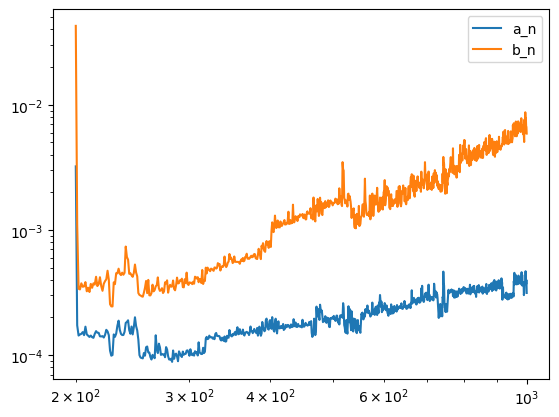

In [3]:
#
def time_Sparse(n):
    b = np.ones(n)
    x_0 = 2*np.ones(n)
    sparse_H = sparse_Hessian(Hessian(x_0))
    start_time=timeit.default_timer()
    scipy.sparse.linalg.spsolve(sparse_H,b)
    stop_time=timeit.default_timer()

    return stop_time-start_time


def time_dense(n):
    b = np.ones(n)
    x_0 = 2*np.ones(n)
    H = Hessian(x_0)
    start_time=timeit.default_timer()
    np.linalg.solve(H,b)
    stop_time=timeit.default_timer()

    return stop_time-start_time

size = np.arange(200,1000)
a_n = np.zeros(800)
b_n = np.zeros(800)

for i in size:
    a_n[i-200] = time_Sparse(i)
    b_n[i-200] = time_dense(i)


plt.loglog(size,a_n,label='a_n')
plt.loglog(size,b_n,label='b_n')
plt.legend()


# Problem 3
(a) The line search with Newton Modification has one general abstract model like below:

In [4]:
import scipy
import numpy as np
def hessian_modification(h):
    beta = 10**(-3)
    n = h.shape[0]
    t = 0

    if np.diagonal(h).min() > 0:
        t = 0
    else:
        t = -h.min() + beta

    not_positive_definite = True
    
    while not_positive_definite:
        try:
            h = h + t*np.identity(n)
            L = scipy.linalg.cholesky(h)
            not_positive_definite = False
        except :
            t = np.maximum(2*t,beta)
            print('catch')
    

    return L.T@L













In [5]:
def f(x):
    return 0

def gradient(f,x):
    return 0

def hessian(f,x):
    return 0

def step_length(f,x,p):
    alpha = 1
    rho = 0.8
    c_1 = 0.6
    while(f(x + alpha*p) > (f(x) + c_1*alpha*np.dot(gradient(f,x),p))):
        alpha = rho*alpha
    return alpha



def hw3_p1(f,x_0,k):
    iteration = 0
    x = x_0
    while iteration < k:
        H = hessian(f,x)
        H_new = hessian_modification(H)
   
        g = gradient(f,x)
        p = scipy.sparse.linalg.spsolve(H_new,-g)
        alpha = step_length(f,x,p)
        x = x + alpha*p
        iteration = iteration + 1
    return x,f(x)



(b) Adjust codes in part (a) to solve Fenton function

In [6]:
# The code from HW 2

from sympy import *

# define the Gradient and Hessian matrix for Fenton function
x, y = symbols('x y')
f = symbols('f', cls=Function)
f = (1/2)*(12+x**2+((1+y**2)/x**2)+(((x*y)**2 + 100)/(x*y)**4))

G = Matrix([f]).jacobian(Matrix(list(f.free_symbols)))
H = hessian(f, [x, y])

def fenton(f,X):
    x_1 = X[0]
    x_2 = X[1]
    f_x = f.subs([(x,x_1), (y,x_2)])
    g = G.subs(x,x_1).subs(y,x_2)
    h = H.subs(x,x_1).subs(y,x_2)

    return f_x,np.array(g).astype(np.float64),np.array(h).astype(np.float64)

def hw2_p3(x_0,k):
    X = x_0
    n = 0
    y_list = np.zeros(k)
    while(n < k):
        f_x,g,h = fenton(f,X)
        y_list[n] = f_x
        X = X + np.linalg.lstsq((-1)*h,g.T)[0].flatten('F')
        n = n + 1
    return X,y_list




In [7]:
# Code for this question

def step_length_p3(f,f_x,g,X,p):
    alpha = 1
    rho = 0.8
    c_1 = 0.6

    x_new = X + alpha*p
    x_1 = x_new[0]
    x_2 = x_new[1]
    f_x_new = f.subs([(x,x_1), (y,x_2)])
    while(f_x_new > (f_x + c_1*alpha*np.dot(g,p))):
        alpha = rho*alpha
        x_new = X + alpha*p
        x_1 = x_new[0]
        x_2 = x_new[1]
        f_x_new = f.subs([(x,x_1), (y,x_2)])
    return alpha

def hw3_p3_b(x_0,k):
    X = x_0
    n = 0
    y_list = np.zeros(k)
    while(n < k):
        f_x,g,h = fenton(f,X)
        y_list[n] = f_x
        h_new = hessian_modification(h)
        h_new = scipy.sparse.csr_matrix(h_new)
        p = scipy.sparse.linalg.spsolve((-1)*h_new,g.T).flatten('F')
        alpha = step_length_p3(f,f_x,g,X,p)
        X = X + alpha*p
        n = n + 1
    
    return X,y_list


/tmp/ipykernel_326/2068752593.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = X + np.linalg.lstsq((-1)*h,g.T)[0].flatten('F')


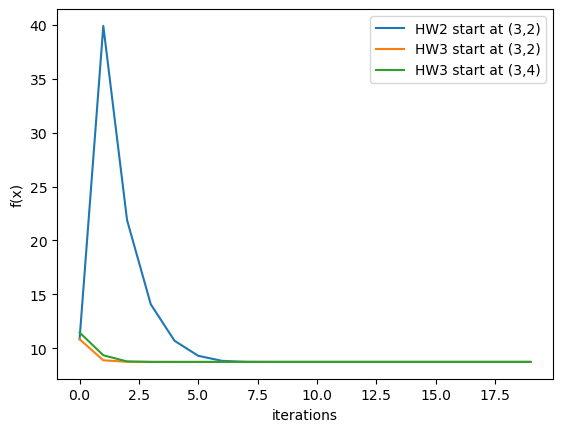

In [8]:
start_1 = np.array([3,2])
start_2 = np.array([3,4])
X_1a,y_list_1a = hw2_p3(start_1,20)
X_1b,y_list_1b = hw3_p3_b(start_1,20)
X_2a,y_list_2a = hw2_p3(start_2,20)
X_2b,y_list_2b = hw3_p3_b(start_2,20)


x_list = np.arange(20)

plt.plot(x_list,y_list_1a,label='HW2 start at (3,2)')
plt.plot(x_list,y_list_1b,label='HW3 start at (3,2)')
# plt.plot(x_list,y_list_2a,label='HW2 start at (3,4)')
plt.plot(x_list,y_list_2b,label='HW3 start at (3,4)')
plt.xlabel('iterations')
plt.ylabel('f(x)')
plt.legend()

The graph shows all convergence behavior for all cases except for the Newton method at (3,4), which will diverge to infinity.

It is obviously to check that modified Newton's method can converge to the solution with stability and speed. The reason is that every direction in modified method must be descent, and the modified hessian is close to the hessian, which guarantees one superlinear convergence rate.
The original Newton method has quadratic convergence rate in the end, but we can see that at point (3,2), it does not go in a right direction in first few iterations, so it takes more time to become close to the solution compared with modified method.

(c) Apply (a) to Rosenbrock function


In [9]:
# define Hessian matrix for Rosenbrock, see question I
def Hessian(x):
    n = int(len(x))
    H = np.zeros((n,n))

    H[0,0] = 1200*(x[0]**2)-400*x[1]+2
    H[0,1] = -400*(x[0])

    for i in range(1,n-1):

        H[i,i-1] = -400*x[i-1]
        H[i,i] = 1200*(x[i]**2)-400*x[i+1]+202
        H[i,i+1] = -400*x[i]
    
    H[n-1,n-2] = -400*x[n-2]
    H[n-1,n-1] = 200

    return H


# define Gradient for Rosenbrock

def Gradient_Rosenbrock(x):
    n = int(len(x))
    G = np.zeros(n)
    G[0] = 400*(x[0]**3)-400*x[0]*x[1]+2*x[0]-2
    for i in range(1,n-1):
        G[i] = 200*x[i] - 200*(x[i-1]**2) + 400*(x[i]**3) - 400*x[i]*x[i+1] + 2*x[i] - 2

    G[n-1] = 200*(x[n-1] - (x[n-2]**2))

    return G

# define function value of Rosenbrock

def f_Rosenbrock(x):
    f = 0
    n = int(len(x))

    for i in range(n-1):
        f = f + 100*(x[i+1] - (x[0]**2))**2 + (x[i] - 1)**2
    

    return f


# combine above parameters

def Rosenbrock(x):
    return f_Rosenbrock(x),Gradient_Rosenbrock(x),Hessian(x)


In [10]:
# Code for this question

def step_length_Rosenbrock(f_x,g,X,p):
    alpha = 1
    rho = 0.8
    c_1 = 0.5
    x_new = X + alpha*p
    
    f_x_new = f_Rosenbrock(x_new)
    
    special_count = 1
    
    while(f_x_new > (f_x + c_1*alpha*np.dot(g,p))):
        alpha = rho*alpha
        x_new = X + alpha*p
        f_x_new = f_Rosenbrock(x_new)
        special_count = special_count + 1

        if(special_count == 6):
            alpha = 1
            return alpha,special_count
    return alpha,special_count

def hw4_nmhm(x_in,niter,eps):
    X = x_in
    n = 0
    g = Gradient_Rosenbrock(X)

    threshold = np.linalg.norm(g)/100


    number_solve = 0
    number_evaluate = 0


    while(n < niter and np.linalg.norm(g) > np.minimum(eps,threshold)):
        f_x,g,h = Rosenbrock(X)
        h_new = hessian_modification(h)
        h_new = scipy.sparse.csr_matrix(h_new)
        p = scipy.sparse.linalg.spsolve((-1)*h_new,g.T).flatten('F')
        alpha,counts = step_length_Rosenbrock(f_x,g,X,p)
        X = X + alpha*p
        n = n + 1

        number_solve = number_solve + 1
        number_evaluate = number_evaluate + counts
    
    return X,number_solve,number_evaluate


In [11]:
A = 2*np.ones(3)
# B = np.array([1.6945276 , 2.07387433, 3.89549733])
# C = np.array([-0.18361487,0.09035557,0.78022962])
# D = B + 0.1*C
# # print(Gradient_Rosenbrock(B).T @ C)
print(hw4_nmhm(A,10,10**(-3)))
# # print(f_Rosenbrock(B-0.1*C))

(array([1.00049463, 1.00094736, 1.00189556]), 10, 21)


In [12]:
# compute time cost for start point at (5,...,5) and (10,...,10)

time_list_5 = np.zeros(90)
time_list_10 = np.zeros(90)
niter = 100
eps = 10**(-5)
for i in range(10,100):
    x = 5*np.ones(i)
    start_time=timeit.default_timer()
    hw4_nmhm(x,niter,eps)
    stop_time=timeit.default_timer()
    time_list_5[i-10] = stop_time - start_time


for i in range(10,100):
    x = 10*np.ones(i)
    start_time=timeit.default_timer()
    hw4_nmhm(x,niter,eps)
    stop_time=timeit.default_timer()
    time_list_10[i-10] = stop_time - start_time



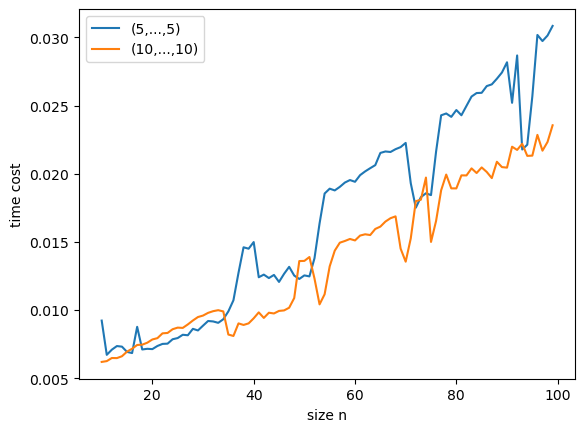

In [13]:
iteration_list = np.arange(10,100)

plt.plot(iteration_list,time_list_5,label='(5,...,5)')
plt.plot(iteration_list,time_list_10,label='(10,...,10)')
plt.xlabel('size n') 
plt.ylabel('time cost')
plt.legend() 

# Problem 4

(b) Design one abstract model for Trust Region with Dogleg Method. The algorithm designed below can show the total number of solved linear equations and function evaluations. It can also output the function graph to check whether we get one convergent minimizer.

In [14]:
# This is a general model with one specific function f

def f(x):
    return 0

def gradient(x):
    return 0

def hessian(x):
    return 0

def parameters(x):
    f_x = 0
    g = 0
    h = 0
    return f_x,g,h

# Define quadratic model m_k
def m_k(x,p):
    f_x,g,h = parameters(x)

    m = f_x + np.dot(g,p) + 0.5*(p.T @ h @ p)

    return m

def dogleg(x,delta):

    f_x,g,h = parameters(x)

    h_sparse = scipy.sparse.csr_matrix(h)

    p_B = scipy.sparse.linalg.spsolve(-h,g)

    p_U = (-1*(g.T @ g))/(g.T @ h @ g)

    p_dif = p_B - p_U

    p_B_norm = np.linalg.norm(p_B)
    p_U_norm = np.linalg.norm(p_U)
    p_dif_norm = np.linalg.norm(p_dif)


    # Decide tao value
    tao = 0

    if p_B_norm <= delta:
        tao = 2

    elif p_U_norm >= delta:
        tao = delta/p_U_norm
    else:
        f = (p_U.T @ p_dif)*(p_U.T @ p_dif)
        tao_sub = -2*(p_U.T @ p_dif) + 2*(np.math.sqrt(f - p_dif_norm*p_dif_norm*(p_U_norm**2 - delta**2)))
        tao = tao_sub/(2*p_dif_norm*p_dif_norm) + 1
    
    # Decide p

    if tao <= 1:
        p = tao*p_U
    elif 1 < tao <=2:
        p = p_U + (tao-1)*p_dif

    return p
        
    
# main trusted region method

def Trust_Region(x,niter,eps):
    k = 0
    number_solve_equation = 0
    number_evaluation = 0

    y_list = np.zeros(100)

    delta_max = 0.5
    delta = delta_max

    g = gradient(x)
    number_evaluation = number_evaluation + 1


    
    while(k < niter and np.linalg.norm(g) > eps):
        p = dogleg(x,delta)

        number_evaluation = number_evaluation + 3
        number_solve_equation = number_solve_equation + 1

        x_new = x + p

        f_x = f(x)
        y_list[k] = f_x

        f_x_new = f(x_new)
        number_evaluation = number_evaluation + 2

        rho = (f_x - f_x_new)/(m_k(x,np.zeros(len(p))) - m_k(x,p))
        number_evaluation = number_evaluation + 2

        if rho < 0.25:
            delta = delta/4
        elif rho > 0.75 and np.linalg.norm(p) == delta:
            delta = np.min((2*delta),delta_max)

        if rho > 0.25:
            x = x_new
            k = k + 1
    
    return x,number_solve_equation,number_evaluation,y_list

        

        



(c) Apply the algorithm to Rosenbrock function with increasing n size.

In [15]:
# define Hessian matrix for Rosenbrock, see question I
def Hessian(x):
    n = int(len(x))
    H = np.zeros((n,n))

    H[0,0] = 1200*(x[0]**2)-400*x[1]+2
    H[0,1] = -400*(x[0])

    for i in range(1,n-1):

        H[i,i-1] = -400*x[i-1]
        H[i,i] = 1200*(x[i]**2)-400*x[i+1]+202
        H[i,i+1] = -400*x[i]
    
    H[n-1,n-2] = -400*x[n-2]
    H[n-1,n-1] = 200

    return H


# define Gradient for Rosenbrock

def Gradient_Rosenbrock(x):
    n = int(len(x))
    G = np.zeros(n)
    G[0] = 400*(x[0]**3)-400*x[0]*x[1]+2*x[0]-2
    for i in range(1,n-1):
        G[i] = 200*x[i] - 200*(x[i-1]**2) + 400*(x[i]**3) - 400*x[i]*x[i+1] + 2*x[i] - 2

    G[n-1] = 200*(x[n-1] - (x[n-2]**2))

    return G

# define function value of Rosenbrock

def f_value(x):
    f = 0
    n = int(len(x))

    for i in range(n-1):
        f = f + 100*(x[i+1] - (x[0]**2))**2 + (x[i] - 1)**2
    

    return f


# combine above parameters

def parameter(x):
    return f_value(x),Gradient_Rosenbrock(x),Hessian(x)


# Define quadratic model m_k
def m_k(x,p):
    f_x,g,h = parameter(x)

    m = f_x + np.dot(g,p) + 0.5*np.dot(np.dot(p.T,h),p)

    return m

def dogleg(x,delta):

    f_x,g,h = parameter(x)

    h_sparse = scipy.sparse.csr_matrix(h)

    p_B = scipy.sparse.linalg.spsolve(-h_sparse,g)

    p_U = ((-1*(np.dot(g.T,g)))/(np.dot(g.T,h).dot(g)))*g

    p_dif = p_B - p_U

    p_B_norm = np.linalg.norm(p_B)
    p_U_norm = np.linalg.norm(p_U)
    p_dif_norm = np.linalg.norm(p_dif)


    # Decide tao value
    tao = 0

    if p_B_norm <= delta:
        tao = 2

    elif p_U_norm >= delta:
        tao = delta/p_U_norm
    else:
        f = (np.dot(p_U.T,p_dif))*(np.dot(p_U.T,p_dif))
        tao_sub = -2*(np.dot(p_U.T,p_dif)) + 2*(np.math.sqrt(f - p_dif_norm*p_dif_norm*(p_U_norm**2 - delta**2)))
        tao = tao_sub/(2*p_dif_norm*p_dif_norm) + 1
    
    # Decide p

    if tao <= 1:
        p = tao*p_U
    elif 1 < tao <=2:
        p = p_U + (tao-1)*p_dif

    return p
        
    
# main trusted region method for Rosenbrock function

def hw4_tr_ls(x,niter,eps):
    k = 0
    number_solve_equation = 0
    number_evaluation = 0

    delta_max = 20
    delta = delta_max

    g = Gradient_Rosenbrock(x)
    number_evaluation = number_evaluation + 1

    threshold = np.linalg.norm(g)/100

    
    while(k < niter and np.linalg.norm(g) > np.minimum(eps,threshold)):
        p = dogleg(x,delta)

        number_evaluation = number_evaluation + 3
        number_solve_equation = number_solve_equation + 1

        x_new = x + p

        f_x = f_value(x)

        f_x_new = f_value(x_new)
        number_evaluation = number_evaluation + 2

        rho = (f_x - f_x_new)/(m_k(x,np.zeros(len(p))) - m_k(x,p))

        number_evaluation = number_evaluation + 2

        # we will meet the case 0/0, python defined as NaN
        if np.isnan(rho):
            break
        
        # special case if rho < o and f can never decrease along direction p
        if rho < 0:

            x = x_new
            g = Gradient_Rosenbrock(x)
            number_evaluation = number_evaluation + 1
            k = k + 1
            continue

        if rho < 0.25:
            delta = delta/4
        elif rho > 0.75 and np.linalg.norm(p) == delta:
        
            delta = np.minimum(2*delta,delta_max)
        else:
            pass

        if rho > 0.25:
            x = x_new
        
        g = Gradient_Rosenbrock(x)
        number_evaluation = number_evaluation + 1

        k = k + 1
    
    return x,number_solve_equation,number_evaluation

        

        




In [16]:

for i in range(30,200):
    x = 10*np.ones(i)
    hw4_tr_ls(x,200,10**(-3))

/tmp/ipykernel_326/3306797199.py:130: RuntimeWarning: invalid value encountered in double_scalars
  rho = (f_x - f_x_new)/(m_k(x,np.zeros(len(p))) - m_k(x,p))


(d) Compare (c) to Problem 3 part (c)

In [17]:
solve_list_Newton = np.zeros(190)
evaluate_list_Newton = np.zeros(190)

solve_list_TR = np.zeros(190)
evaluate_list_TR = np.zeros(190)

x_list = np.arange(10,200)

eps = 10**(-3)
for i in x_list:
    x = 2*np.ones(i)
    X,solve_list_Newton[i-10],evaluate_list_Newton[i-10] = hw4_nmhm(x,200,eps)
    X,solve_list_TR[i-10],evaluate_list_TR[i-10] = hw4_tr_ls(x,200,eps)

/tmp/ipykernel_326/3306797199.py:130: RuntimeWarning: invalid value encountered in double_scalars
  rho = (f_x - f_x_new)/(m_k(x,np.zeros(len(p))) - m_k(x,p))


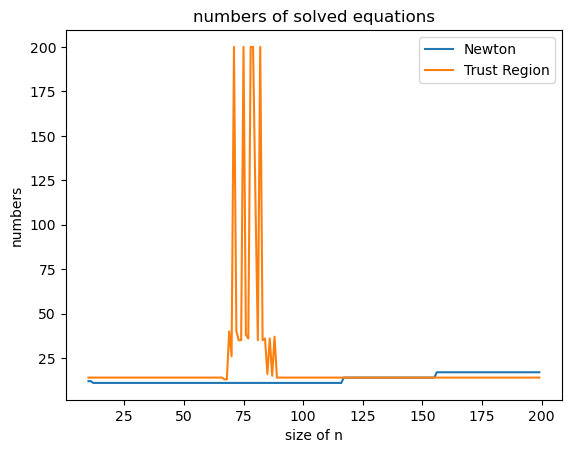

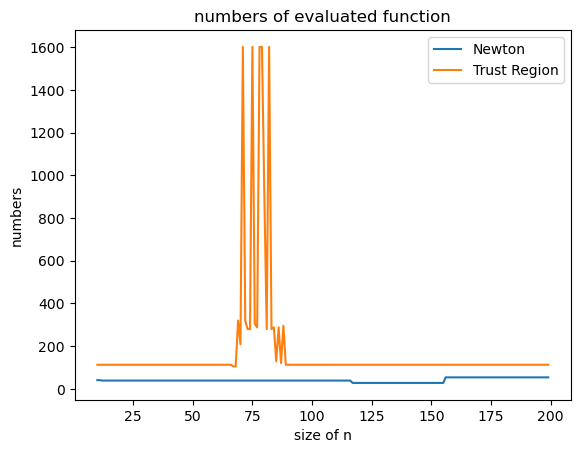

In [18]:
plt.plot(x_list,solve_list_Newton,label='Newton')
plt.plot(x_list,solve_list_TR,label='Trust Region')
plt.xlabel('size of n')
plt.ylabel('numbers')
plt.title('numbers of solved equations')
plt.legend()

plt.figure()

plt.plot(x_list,evaluate_list_Newton,label='Newton')
plt.plot(x_list,evaluate_list_TR,label='Trust Region')
plt.xlabel('size of n')
plt.ylabel('numbers')
plt.title('numbers of evaluated function')
plt.legend()


Ignoring the diverge case of trust region method.
The newton method generally has less function evaluations and similar numbers of linear equations solves.
The reason is possibily that both methods have superlinear convergence rate. Trust Region includes more function evaluations for radius loops, and both methods has only one sparse matrix solve in each iteration.